In [2]:
##
import os 
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")



llm = ChatGroq(model = "llama-3.2-1b-preview",
            groq_api_key = GROQ_API_KEY)

### Import Necessary Libraries


In [12]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START

In [5]:
tavily_tool = TavilySearchResults(max_results=5)


"""
@tool
def research(prompt):
    "Should do a web search for reserching about the given topic."
    response = tavily_tool.invoke(prompt)
    return response
    """

'\n@tool\ndef research(prompt):\n    "Should do a web search for reserching about the given topic."\n    response = tavily_tool.invoke(prompt)\n    return response\n    '

In [28]:
ans = tavily_tool.run("who is elon musk?")
print(ans)

[{'url': 'https://www.britannica.com/money/Elon-Musk', 'content': 'Elon Musk (born June 28, 1971, Pretoria, South Africa) South African-born American entrepreneur who cofounded the electronic-payment firm PayPal and formed SpaceX, maker of launch vehicles and spacecraft.He was also one of the first significant investors in, as well as chief executive officer of, the electric car manufacturer Tesla. In addition, Musk acquired Twitter (later X) in 2022.'}, {'url': 'https://www.investopedia.com/articles/personal-finance/061015/how-elon-musk-became-elon-musk.asp', 'content': "“Elon Musk Tried to Pitch the Head of the Yellow Pages Before the Internet Boom: ‘He Threw the Book at Me’.”\nCompaq Computer, via U.S. Securities and Exchange Commission. SpaceX\nMusk used most of the proceeds from his PayPal stake to found Space Exploration Technologies Corp., the rocket's developer commonly known as SpaceX. By his own account, Musk spent $100 million to found SpaceX in 2002.\n Musk subsequently set

### Set Up State Management and Error Handling


In [6]:
def handle_tool_error(state) -> dict:
    """
    Function to handle errors that occur during tool execution.
    
    Args:
        state (dict): The current state of the AI agent, which includes messages and tool call details.
    
    Returns:
        dict: A dictionary containing error messages for each tool that encountered an issue.
    """
    # Retrieve the error from the current state
    error = state.get("error")
    
    # Access the tool calls from the last message in the state's message history
    tool_calls = state["messages"][-1].tool_calls
    
    # Return a list of ToolMessages with error details, linked to each tool call ID
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",  # Format the error message for the user
                tool_call_id=tc["id"],  # Associate the error message with the corresponding tool call ID
            )
            for tc in tool_calls  # Iterate over each tool call to produce individual error messages
        ]
    }

def create_tool_node_with_fallback(tools: list) -> dict:
    """
    Function to create a tool node with fallback error handling.
    
    Args:
        tools (list): A list of tools to be included in the node.
    
    Returns:
        dict: A tool node that uses fallback behavior in case of errors.
    """
    # Create a ToolNode with the provided tools and attach a fallback mechanism
    # If an error occurs, it will invoke the handle_tool_error function to manage the error
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],  # Use a lambda function to wrap the error handler
        exception_key="error"  # Specify that this fallback is for handling errors
    )

### Define the State and Assistant Class

In [29]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable):
        # Initialize with the runnable that defines the process for interacting with the tools
        self.runnable = runnable

    def __call__(self, state: State):
        while True:
            # Invoke the runnable with the current state (messages and context)
            print("Current state before running tool:", state)
            result = self.runnable.invoke(state)
            

            # Check if the tool was invoked and returned valid results
            print("Result after tool execution:", result)  # DEBUG
            
            # If the tool fails to return valid output, re-prompt the user to clarify or retry
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # Add a message to request a valid response
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                # Break the loop when valid output is obtained
                break

        # Return the final state after processing the runnable
        return {"messages": result}

### Define the Assistant’s Workflow


In [30]:
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            '''You are a thorough and efficient research assistant. Your job is to conduct in-depth research on the given topic, 
            identifying key points, trends, and insights. Summarize the information in a clear, concise format, highlighting relevant examples, 
            sources, and comparisons where necessary. Your summary should be objective, well-structured, 
            and suitable for a professional audience with intermediate knowledge of the subject.
            
            You should get the following information from them:
            - Topic
            If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

            After you are able to discern all the information, call the relevant tool.
            ''',
        ),
        ("placeholder", "{messages}"),
    ]
)

In [31]:
research_tool = [tavily_tool]

In [32]:
# Bind the tools to the assistant's workflow
research_assistant_runnable = primary_assistant_prompt | llm.bind_tools(research_tool)

### Build the Graph Structure


In [33]:
builder = StateGraph(State)
builder.add_node("assistant", Assistant(research_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(research_tool))

builder.add_edge(START, "assistant")  # Start with the assistant
builder.add_conditional_edges("assistant", tools_condition)  # Move to tools after input
builder.add_edge("tools", "assistant")  # Return to assistant after tool execution


graph = builder.compile()


In [34]:
# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
 "who is elon musk?"
]

In [44]:
_printed = set()
for question in tutorial_questions:
    events = graph.stream(
        {"messages": ("user", question)}, stream_mode="values"
    )
    for event in events:
        print(event)
        print("--------------------------------------")
        human_message = event['messages'][0].content
        print("Human_message:", human_message)
        print("-------------------------------------")


        

{'messages': [HumanMessage(content='who is elon musk?', additional_kwargs={}, response_metadata={}, id='998ede71-3df4-4175-9370-a268996a8d07')]}
--------------------------------------
Human_message: who is elon musk?
-------------------------------------
Current state before running tool: {'messages': [HumanMessage(content='who is elon musk?', additional_kwargs={}, response_metadata={}, id='998ede71-3df4-4175-9370-a268996a8d07')]}
Result after tool execution: content='<function=tavily_search_results_json{"query": "elon musk"}}{"name": "elon musk", "description": "Elon Musk is a South African-born entrepreneur, inventor, and business magnate. He is the CEO of SpaceX and Tesla, Inc., and has become one of the most influential and successful entrepreneurs in the world.", "parameters": {"properties": {"name": {"description": "Full name", "type": "string"}},"required": "[]"}}' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 422, 'total_toke

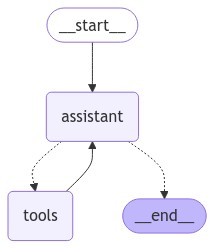

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass